In [2]:
# importing dependencies
import pytrends
from pytrends.request import TrendReq
import pandas as pd
from datetime import date, datetime, timedelta

In [53]:
def getData(keyword):
    # Specify the parameters to your liking
    startDate="2004-10-24"
    endDate="2020-12-26"
    start_date= date(2004, 10, 24) # specify your start date
    end_date= date(2020, 12, 26) # specify your end date
    key_word = keyword # use one key word
    _cat = 0 # Category to narrow down your results
    _geo = 'US' # Two letter country abbreviation
    _gprop = '' # What Google property to filter to (e.g 'images')
    _hl = 'en-US' # Specify Language and Region
    _tz = 360 # specify your time-zone
    # Source for this function: https://stackoverflow.com/questions/10688006/generate-a-list-of-datetimes-between-an-interval
    def perdelta(start, end, delta):
        curr = start
        while curr < end:
            yield curr
            curr += delta
    # generating a list of dates with 90 day intervals
    dates=[]
    for res in perdelta(start_date, end_date, timedelta(days=90)):
        dates.append(res)  
    dates.append(end_date)
    # gettingt the data for the individual time frames and adding them to a list
    appended_data = []
    for i in range(len(dates)-1):
        try: 
            _timeframe = str(dates[i]) + ' ' + str(dates[i+1])
            totalTrend = TrendReq(hl=_hl, tz=_tz)
            totalTrend.build_payload([key_word], cat=_cat, timeframe=_timeframe, geo=_geo, gprop=_gprop)
            totalTrend = totalTrend.interest_over_time()
            appended_data.append(totalTrend)
        except KeyError: 
            print('Please specify the Parameters (e.g. Keyword)')
            break
    # correcting the values of the individual time-frames
    for i in range(len(appended_data)-1):
        x = appended_data[i][key_word].tail(1).values
        y = appended_data[i+1][key_word].head(1).values
        if x == 0 and y == 0:
            factor = 1
        elif x == 0:
            factor = 0.5/y
        elif y == 0:
            factor = x/0.5
        else:
            factor = x/y
        appended_data[i+1][key_word] = appended_data[i+1][key_word] * factor
    # concatinating all the dfs to one complete dataframe
    appended_df = pd.concat(appended_data, axis=0)
    # deleting the duplicated indexes/rows
    appended_df = appended_df[~appended_df.index.duplicated(keep='first')]
    # saving the daily data as a csv
    logic = {key_word:"sum" }
    offset = pd.to_timedelta(-6, unit='d')
    appended_df=appended_df.resample('W', loffset=offset).apply(logic)
    return appended_df 

In [54]:
welfare=["Social Security","Social Security Office Locations","Unemployment Benefits","Social Security Gov", 
         "Unemployment Office","Food Stamps", "Department of Labor","Monster","Indeed","Jobs","Job Search",
         "Resume","Job Search Engines","Linkedin","Hotjobs","Cover Letter"]

In [55]:
import time
for i in welfare:
    df=getData(i)
    df.to_excel("Daily_To_Weekly"+i+".xlsx")  
    time.sleep(60)
    

ResponseError: The request failed: Google returned a response with code 429.

In [52]:
df.tail()

,Social Security Office Locations
date,
2020-11-23,94.0
2020-11-30,98.0
2020-12-07,174.0
2020-12-14,44.0
2020-12-21,46.0


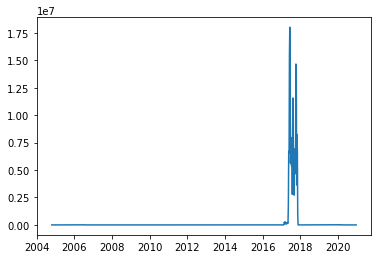

In [51]:
from matplotlib import pyplot as plt
# appended_df=appended_df.drop(columns={"isPartial"})
plt.plot(df)